This uses cell values that i tried to make equivalent to OD and Alberto's Experiments to justify using his numbers. 
Basically the logic was that I measured CFUs for my solid growth experiment and then used the idea that 1.0 OD is approximately equal to 10^7cells/mL. So I divided all my CFU values by 10^7 to convert them to "OD". 

Alberto kept all of his cells in log phase for his experiments so he didnt have to account for growth so I am assuming his production rate is accurate at 1.0 "OD" and will use this factor to scale up or down production rate accordingingly. Maybe I should check those assumptions with Eric and Georg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter



Analyzing strain: beta->alpha


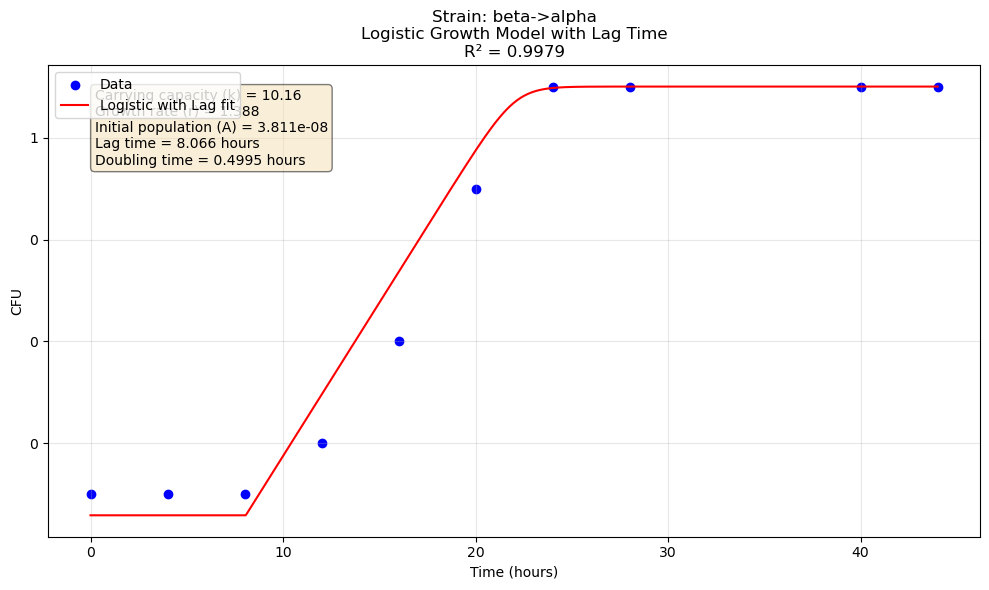


Results for strain: beta->alpha
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 10.1569
  Growth rate (r): 1.3877
  Initial population (A): 3.81124e-08
  Lag time: 8.06593 hours
  Doubling time: 0.499493 hours
  R-squared: 0.997859

Analyzing strain: alpha->venus


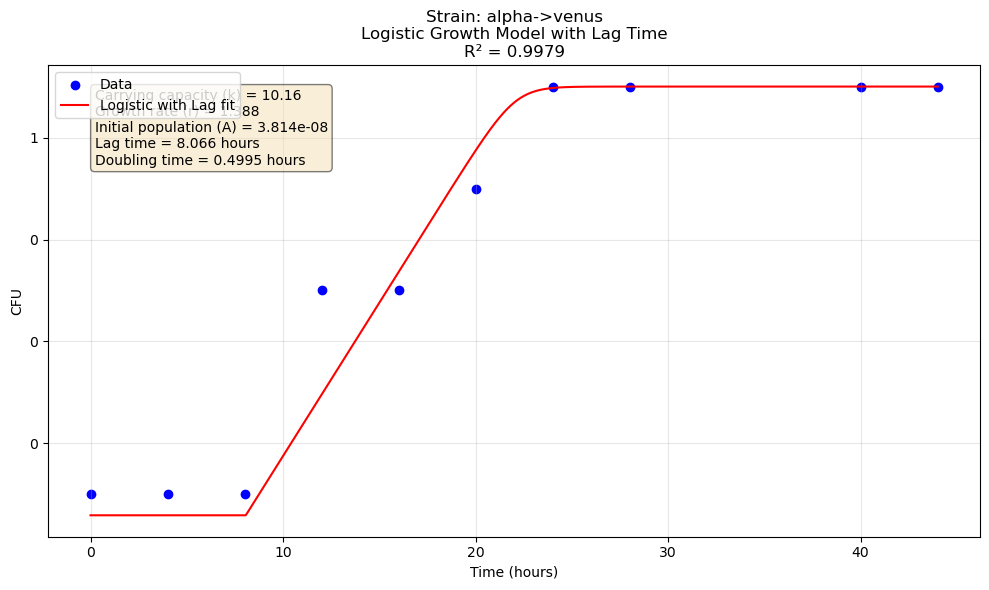


Results for strain: alpha->venus
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 10.1569
  Growth rate (r): 1.38765
  Initial population (A): 3.81425e-08
  Lag time: 8.06591 hours
  Doubling time: 0.499513 hours
  R-squared: 0.997859

Analyzing strain: alpha->alpha


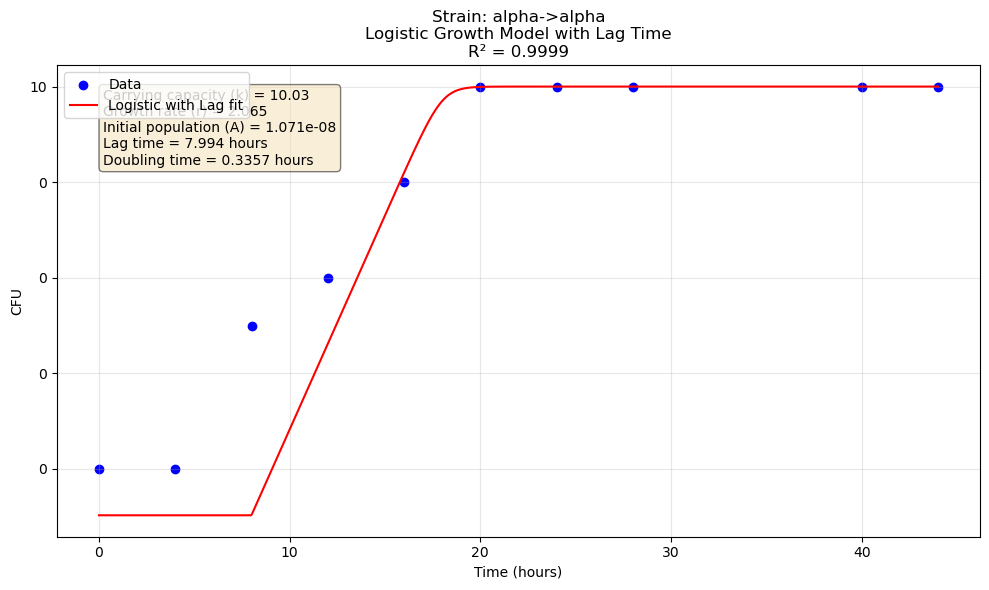


Results for strain: alpha->alpha
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 10.0306
  Growth rate (r): 2.06452
  Initial population (A): 1.07059e-08
  Lag time: 7.99429 hours
  Doubling time: 0.335742 hours
  R-squared: 0.999905

Analyzing strain: alpha->IAA


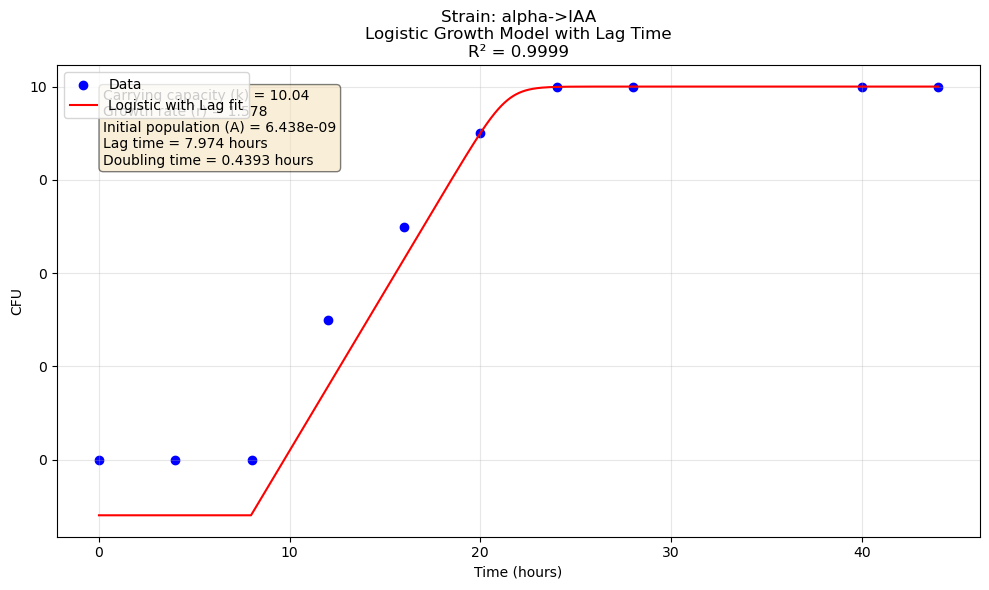


Results for strain: alpha->IAA
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 10.0403
  Growth rate (r): 1.5778
  Initial population (A): 6.43804e-09
  Lag time: 7.97397 hours
  Doubling time: 0.439311 hours
  R-squared: 0.999916

Analyzing strain: beta->IAA


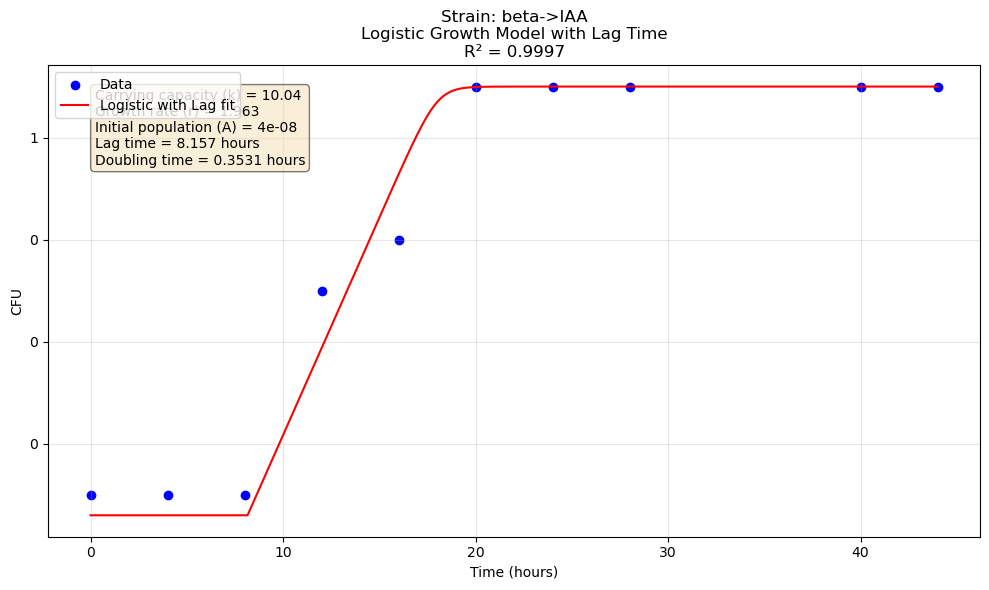


Results for strain: beta->IAA
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 10.0403
  Growth rate (r): 1.96296
  Initial population (A): 4.0001e-08
  Lag time: 8.15673 hours
  Doubling time: 0.353113 hours
  R-squared: 0.999744

Analyzing strain: IAA->GFP


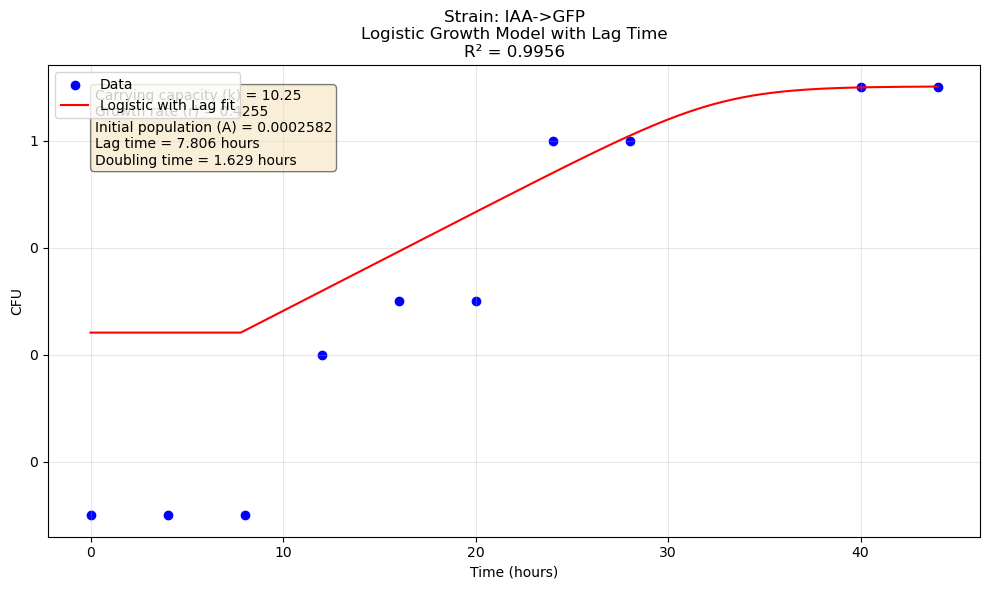


Results for strain: IAA->GFP
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 10.2527
  Growth rate (r): 0.425495
  Initial population (A): 0.000258204
  Lag time: 7.80588 hours
  Doubling time: 1.62904 hours
  R-squared: 0.995558

Analyzing strain: IAA->IAA


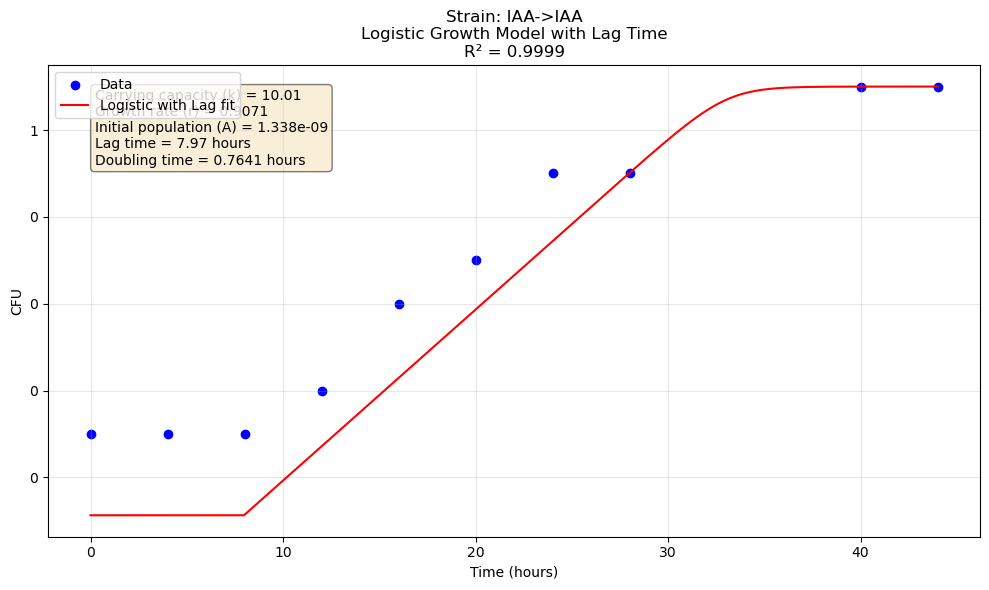


Results for strain: IAA->IAA
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 10.0092
  Growth rate (r): 0.907148
  Initial population (A): 1.33805e-09
  Lag time: 7.97017 hours
  Doubling time: 0.764095 hours
  R-squared: 0.99994

Analyzing strain: IAA->alpha


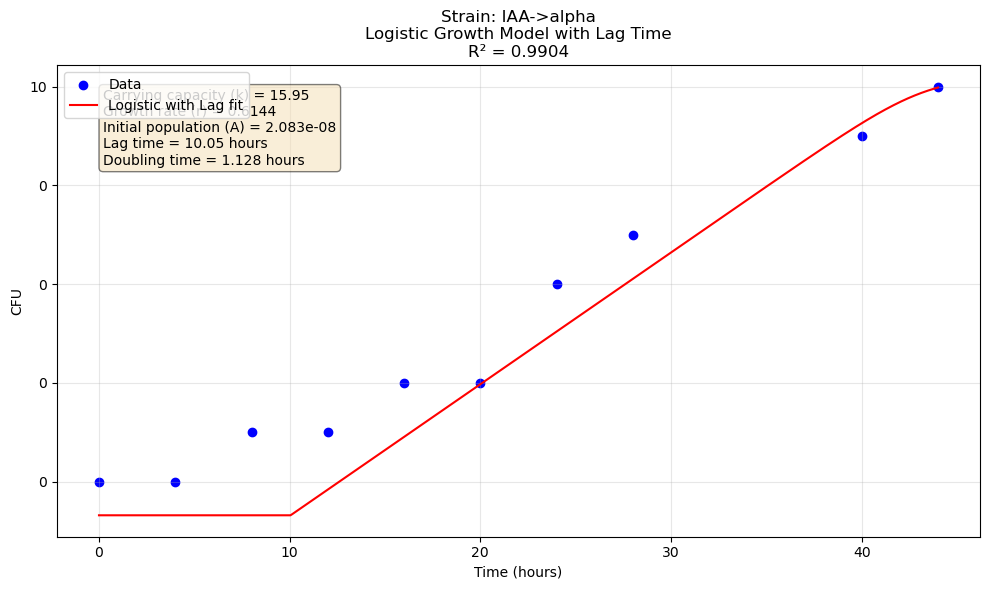


Results for strain: IAA->alpha
Logistic Growth Model with Lag Time Parameters:
  Carrying capacity (k): 15.9475
  Growth rate (r): 0.614406
  Initial population (A): 2.08268e-08
  Lag time: 10.048 hours
  Doubling time: 1.12816 hours
  R-squared: 0.990412


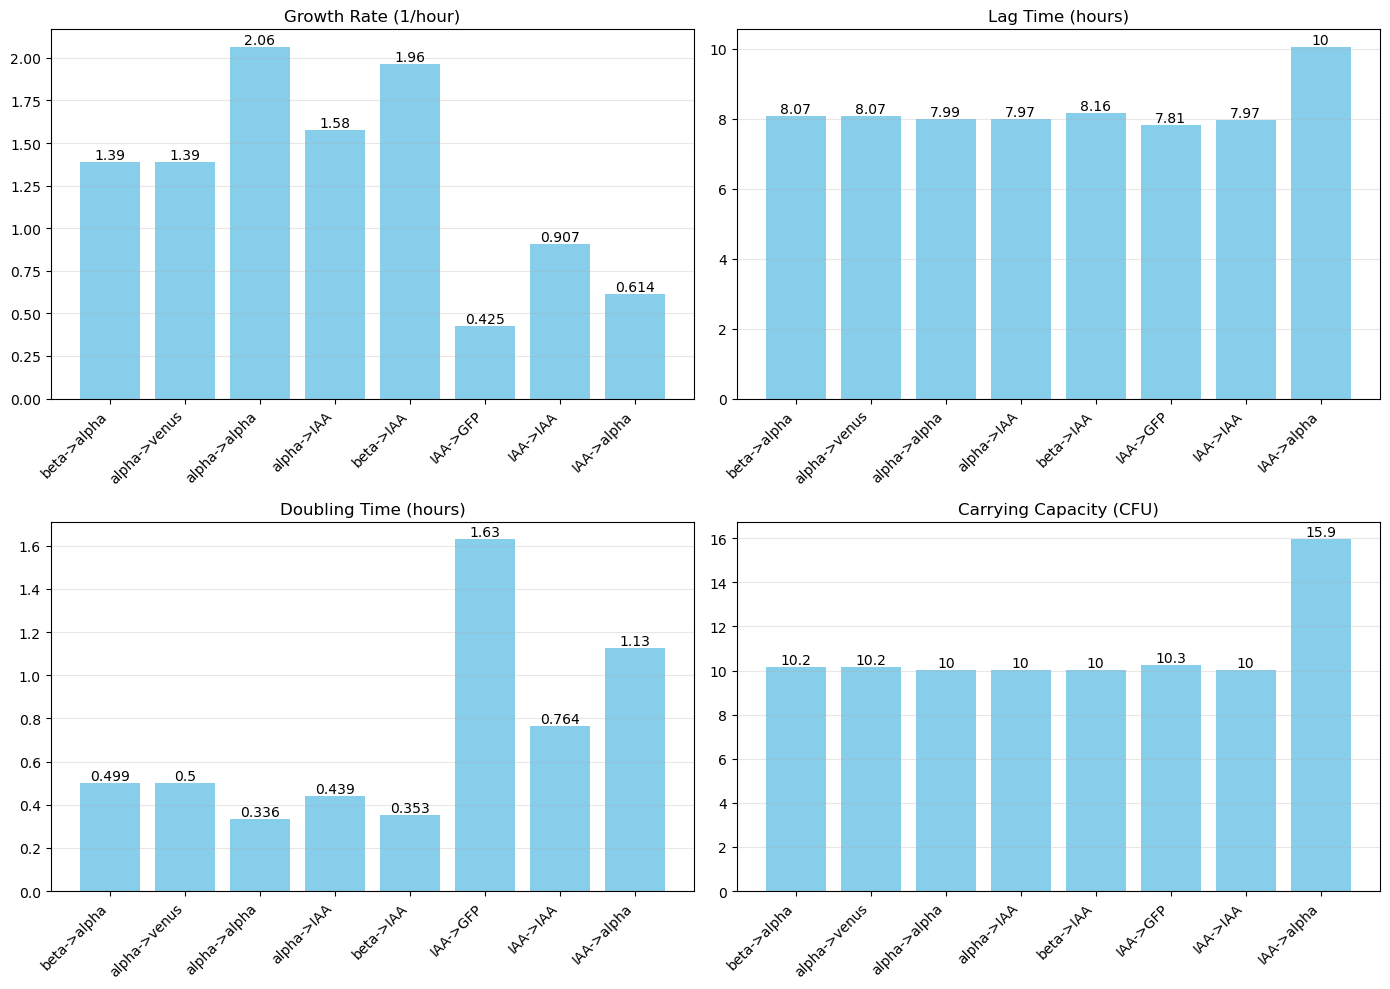


Summary of Growth Parameters:
--------------------------------------------------------------------------------
Strain              Growth Rate (1/hour)     Lag Time (hours)         Doubling Time (hours)    Carrying Capacity (CFU)  
--------------------------------------------------------------------------------
beta->alpha         1.388                    8.066                    0.4995                   10.16                    
alpha->venus        1.388                    8.066                    0.4995                   10.16                    
alpha->alpha        2.065                    7.994                    0.3357                   10.03                    
alpha->IAA          1.578                    7.974                    0.4393                   10.04                    
beta->IAA           1.963                    8.157                    0.3531                   10.04                    
IAA->GFP            0.4255                   7.806                    1.629      

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter
import os

def logistic_with_lag_model(t, k, r, A, lag):
    """
    Logistic growth model with lag phase
    
    Parameters:
    -----------
    t : array-like
        Time points
    k : float
        Carrying capacity (maximum population)
    r : float
        Growth rate
    A : float
        Initial population
    lag : float
        Lag time (delay before growth begins)
    
    Returns:
    --------
    array-like
        Population at each time point
    """
    # Return initial population during lag phase
    growth = np.ones_like(t) * A
    # Apply logistic model after lag time
    mask = t > lag
    growth[mask] = k / (1 + ((k - A) / A) * np.exp(-r * (t[mask] - lag)))
    return growth

def calculate_doubling_time(r):
    """Calculate doubling time from growth rate"""
    return np.log(2) / r

def fit_logistic_lag_model(time, cfu, strain_name, plot=True, output_dir=None):
    """
    Fit logistic growth model with lag time to data
    
    Parameters:
    -----------
    time : array-like
        Time points (hours)
    cfu : array-like
        CFU counts at each time point
    strain_name : str
        Name of the strain (for plot title and saving)
    plot : bool
        Whether to plot the results
    output_dir : str
        Directory to save plots (if None, plots won't be saved)
    
    Returns:
    --------
    dict
        Dictionary with model parameters:
        - k: carrying capacity
        - r: growth rate
        - A: initial population
        - lag: lag time
        - doubling_time: calculated doubling time
        - r_squared: R-squared value for goodness of fit
    """
    # Convert inputs to numpy arrays
    time = np.array(time)
    cfu = np.array(cfu)
    
    # Initial parameter guesses
    k_guess = np.max(cfu) * 1.1  # Carrying capacity
    r_guess = 0.5                # Growth rate
    A_guess = cfu[0]             # Initial population
    lag_guess = time[int(len(time)/5)]  # Lag time (1/5 of time course)
    
    # Parameter bounds (all non-negative)
    bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
    
    try:
        # Fit the model
        popt, pcov = curve_fit(
            logistic_with_lag_model,
            time,
            cfu,
            p0=[k_guess, r_guess, A_guess, lag_guess],
            bounds=bounds,
            maxfev=20000  # Increase maximum function evaluations
        )
        
        # Extract parameters
        k, r, A, lag = popt
        
        # Calculate R-squared
        y_pred = logistic_with_lag_model(time, *popt)
        ss_tot = np.sum((cfu - np.mean(cfu))**2)
        ss_res = np.sum((cfu - y_pred)**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Calculate doubling time
        doubling_time = calculate_doubling_time(r)
        
        # Create parameter dictionary
        params = {
            'strain': strain_name,        # Strain name
            'k': k,                       # Carrying capacity
            'r': r,                       # Growth rate
            'A': A,                       # Initial population
            'lag': lag,                   # Lag time
            'doubling_time': doubling_time,  # Doubling time
            'r_squared': r_squared        # R-squared value
        }
        
        # Plot the results if requested
        if plot:
            # Create smooth time points for plotting
            t_smooth = np.linspace(min(time), max(time), 1000)
            y_smooth = logistic_with_lag_model(t_smooth, *popt)
            
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Plot data and fit
            ax.scatter(time, cfu, color='blue', label='Data')
            ax.plot(t_smooth, y_smooth, 'r-', label='Logistic with Lag fit')
            
            # Use log scale if range is large
            if np.min(cfu) > 0 and np.max(cfu) / np.min(cfu) > 10:
                ax.set_yscale('log')
                ax.yaxis.set_major_formatter(ScalarFormatter())
            
            # Add labels and title
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('CFU')
            ax.set_title(f'Strain: {strain_name}\nLogistic Growth Model with Lag Time\nR² = {r_squared:.4f}')
            
            # Add parameter values to the plot
            param_text = [
                f"Carrying capacity (k) = {k:.4g}",
                f"Growth rate (r) = {r:.4g}",
                f"Initial population (A) = {A:.4g}",
                f"Lag time = {lag:.4g} hours",
                f"Doubling time = {doubling_time:.4g} hours"
            ]
            
            ax.text(0.05, 0.95, "\n".join(param_text), transform=ax.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            # Save plot if output_dir is provided
            if output_dir is not None:
                os.makedirs(output_dir, exist_ok=True)
                plt.savefig(os.path.join(output_dir, f"{strain_name.replace(' ', '_')}_growth_curve.png"), dpi=300)
            
            plt.show()
        
        # Print results
        print(f"\nResults for strain: {strain_name}")
        print("Logistic Growth Model with Lag Time Parameters:")
        print(f"  Carrying capacity (k): {k:.6g}")
        print(f"  Growth rate (r): {r:.6g}")
        print(f"  Initial population (A): {A:.6g}")
        print(f"  Lag time: {lag:.6g} hours")
        print(f"  Doubling time: {doubling_time:.6g} hours")
        print(f"  R-squared: {r_squared:.6g}")
        
        return params
    
    except Exception as e:
        print(f"Failed to fit logistic model with lag time for strain {strain_name}: {e}")
        if plot:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(time, cfu, color='blue', label='Data')
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('CFU')
            ax.set_title(f'Strain: {strain_name}\nFailed to fit logistic model with lag time')
            ax.text(0.5, 0.5, f"Error: {str(e)}", transform=ax.transAxes,
                   horizontalalignment='center', verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
            plt.show()
        return None

def analyze_multiple_strains(data_df, output_dir=None):
    """
    Analyze growth curves for multiple strains in a dataframe
    
    Parameters:
    -----------
    data_df : pandas.DataFrame
        Dataframe with time in the first column and CFU data for each strain in subsequent columns.
        Column names should be the strain names.
    output_dir : str
        Directory to save plots (if None, plots won't be saved)
    
    Returns:
    --------
    dict
        Dictionary with strain names as keys and parameter dictionaries as values
    """
    # Extract time column (first column)
    time = data_df.iloc[:, 0].values
    
    # Get strain names (all columns except the first one)
    strain_names = data_df.columns[1:]
    
    # Dictionary to store parameters for each strain
    all_params = {}
    
    # Analyze each strain
    for strain_name in strain_names:
        print(f"\nAnalyzing strain: {strain_name}")
        cfu = data_df[strain_name].values
        
        # Fit logistic model with lag time
        params = fit_logistic_lag_model(time, cfu, strain_name, plot=True, output_dir=output_dir)
        
        if params is not None:
            all_params[strain_name] = params
    
    return all_params

def compare_strains(all_params, output_dir=None):
    """
    Compare growth parameters between strains
    
    Parameters:
    -----------
    all_params : dict
        Dictionary with strain names as keys and parameter dictionaries as values
    output_dir : str
        Directory to save plots (if None, plots won't be saved)
    """
    if not all_params:
        print("No parameters to compare. All model fits failed.")
        return
    
    # Extract strain names and parameters
    strain_names = list(all_params.keys())
    
    # Parameters to compare
    params_to_compare = ['r', 'lag', 'doubling_time', 'k']
    param_labels = {
        'r': 'Growth Rate (1/hour)',
        'lag': 'Lag Time (hours)',
        'doubling_time': 'Doubling Time (hours)',
        'k': 'Carrying Capacity (CFU)'
    }
    
    # Create a figure with subplots for each parameter
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Plot each parameter
    for i, param in enumerate(params_to_compare):
        ax = axes[i]
        
        # Extract parameter values for each strain
        values = [all_params[strain][param] for strain in strain_names]
        
        # Create bar chart
        bars = ax.bar(range(len(strain_names)), values, color='skyblue')
        
        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3g}', ha='center', va='bottom', rotation=0)
        
        # Set labels and title
        ax.set_title(param_labels[param])
        ax.set_xticks(range(len(strain_names)))
        ax.set_xticklabels(strain_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save plot if output_dir is provided
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, "strain_comparison.png"), dpi=300)
    
    plt.show()
    
    # Create a summary table
    print("\nSummary of Growth Parameters:")
    print("-" * 80)
    header = "Strain".ljust(20)
    for param in params_to_compare:
        header += param_labels[param].ljust(25)
    print(header)
    print("-" * 80)
    
    for strain in strain_names:
        row = strain.ljust(20)
        for param in params_to_compare:
            row += f"{all_params[strain][param]:.4g}".ljust(25)
        print(row)

# Example usage
# Load data from CSV (adjust path as needed)
data_df = pd.read_csv('/home/ec2-user/multicellularcircuits/growthtimecourse_ODnormalized.csv')

#Analyze all strains
output_dir = 'growth_curve_results'  # Set to None to avoid saving plots
all_params = analyze_multiple_strains(data_df, output_dir)

#Compare strains
compare_strains(all_params, output_dir)

#Access parameters for a specific strain
print(all_params)

In [36]:

# Sample data: Time (hours) and CFU/mL counts
data = pd.read_csv('/home/ec2-user/multicellularcircuits/growthtimecourse.csv')
time = data['time'].to_list()
cfu1 = data['beta->alpha'].to_list()
cfu2 = data['alpha->venus'].to_list()
cfu3 = data['alpha->alpha'].to_list()
cfu4 = data['alpha->IAA'].to_list()
cfu5 = data['beta->IAA'].to_list()
cfu6 = data['IAA->GFP'].to_list()
cfu7 = data['IAA->IAA'].to_list()
cfu8 = data['IAA->alpha'].to_list()
print(time)
cfu_list = [cfu1,cfu2,cfu3,cfu4,cfu5,cfu6,cfu7, cfu8]


[0, 4, 8, 12, 16, 20, 24, 28, 40, 44]


In [4]:
all_params

{'beta->alpha': {'strain': 'beta->alpha',
  'k': 10.156865998540457,
  'r': 1.3877019835236286,
  'A': 3.811240700492937e-08,
  'lag': 8.065932810614516,
  'doubling_time': 0.4994928225150461,
  'r_squared': 0.9978592780369944},
 'alpha->venus': {'strain': 'alpha->venus',
  'k': 10.156881939374474,
  'r': 1.3876456633006105,
  'A': 3.814254538133409e-08,
  'lag': 8.06591253743179,
  'doubling_time': 0.4995130953756935,
  'r_squared': 0.9978586598580573},
 'alpha->alpha': {'strain': 'alpha->alpha',
  'k': 10.030632161041991,
  'r': 2.0645209329326293,
  'A': 1.0705887173990125e-08,
  'lag': 7.994289828061679,
  'doubling_time': 0.33574238434838116,
  'r_squared': 0.9999048003122031},
 'alpha->IAA': {'strain': 'alpha->IAA',
  'k': 10.040333303759686,
  'r': 1.577804152831291,
  'A': 6.43804253236298e-09,
  'lag': 7.973971461454354,
  'doubling_time': 0.4393112917823972,
  'r_squared': 0.9999163020148677},
 'beta->IAA': {'strain': 'beta->IAA',
  'k': 10.040307128578494,
  'r': 1.962960502